 # *** A2 Petkovski
# *Classification

In [1]:
# oversampling for class imbalance
!pip install imbalanced-learn
from imblearn.over_sampling import SMOTE 


In [2]:
###############################################################################
### packages required to run code.  
###############################################################################
import re,string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import pandas as pd
import os

from sklearn.manifold import MDS
from sklearn.metrics.pairwise import cosine_similarity

import warnings
warnings.filterwarnings('ignore')

import matplotlib.colors as mcolors


In [105]:
#Custom functions

more_stopwords=["root","editorial","added","though","father","mother","keywords","sourcedate","location","really","review","title","total","ranking","brief","summary","count","would","could","place","ordered","staff","service","experience","private","court"]
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer

def clean_doc(doc): 
    doc = doc.replace("<NL>"," ")
    #split document into individual words
    tokens=doc.split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 4]
    #lowercase all words
    tokens = [word.lower() for word in tokens]
    # filter out stop words
    swl=stopwords.words('english')
    swl.extend(more_stopwords)
    stop_words = set(swl)
    tokens = [w for w in tokens if not w in stop_words]   
    lem = WordNetLemmatizer()
    tokens_lem =[lem.lemmatize(w) for w in tokens]
    #stemmer=PorterStemmer()
    #tokens_stem = [stemmer.stem(w) for w in tokens_lem]
    return tokens_lem

def final_processed_text(doc):
    #this is a function to join the processed text back
    ' '.join(doc)
    return doc

def tfidf(corpus, titles, ngram_range = (1,1), labels=None):
    #this is a function to created the tfidf matrix
    Tfidf=TfidfVectorizer(ngram_range=(1,1))

    #fit the vectorizer using final processed documents.  The vectorizer requires the 
    #stiched back together document.

    TFIDF_matrix=Tfidf.fit_transform(corpus)     

    #creating datafram from TFIDF Matrix
    words = Tfidf.get_feature_names_out()
    matrix=pd.DataFrame(TFIDF_matrix.toarray(), columns=Tfidf.get_feature_names_out(), index=titles)
    return matrix


def One_Hot(variable):
    #this is a function to one hot encode the classes
    LE=LabelEncoder()
    LE.fit(variable)
    Label1=LE.transform(variable)
    OHE=OneHotEncoder()
    labels=OHE.fit_transform(Label1.reshape(-1,1)).toarray()
    return labels



In [106]:
# ****Phrase Extraction******
import spacy

nlp = spacy.load("en_core_web_sm")

def extract_phrases(words):
    text = ' '.join(words)
    doc = nlp(text)
    phrases = [chunk.text for chunk in doc.noun_chunks]
    return ' '.join(phrases)


In [107]:
#****N-gram analysis***** 
from sklearn.feature_extraction.text import TfidfVectorizer

def tfidf_with_ngrams(corpus, titles, ngram_range=(1, 1)):
    Tfidf = TfidfVectorizer(ngram_range=ngram_range)

    TFIDF_matrix = Tfidf.fit_transform(corpus)

    words = Tfidf.get_feature_names_out()
    matrix = pd.DataFrame(TFIDF_matrix.toarray(), columns=words, index=titles)
    return matrix


In [108]:
#mcolors.XKCD_COLORS

In [109]:
import matplotlib.colors as mcolors
def plot_tfidf_matrix(cluster_title,clusters,TFIDF_matrix):
    # convert two components as we're plotting points in a two-dimensional plane
    # "precomputed" because we provide a distance matrix
    # we will also specify `random_state` so the plot is reproducible.
    

    mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

    dist = 1 - cosine_similarity(TFIDF_matrix)

    pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

    xs, ys = pos[:, 0], pos[:, 1]


    #set up colors per clusters using a dict.  number of colors must correspond to K


    cluster_colors = {0: 'red', 1: 'green', 2: 'blue', 3: 'orange', 4: 'yellow', 
                      5:'#bffe28', 6:'pink', 7:'purple',8:'grey',9:'black',10:'cyan',11:'magenta',12:'brown',13:'#d4ffff',
                     14:'#017374',15:'#d3b683',16:'#4f738e'}


    #set up cluster names using a dict.  
    cluster_dict=cluster_title

    #create data frame that has the result of the MDS plus the cluster numbers and titles
    df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=range(0,len(clusters)))) 

    #group by cluster
    groups = df.groupby('label')

    fig, ax = plt.subplots(figsize=(5,5)) # set size
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

    #iterate through groups to layer the plot
    #note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
    for name, group in groups:
        ax.plot(group.x, group.y, marker='o', linestyle='', ms=12,
                label=cluster_dict[name], color=cluster_colors[name], 
                mec='none')
        ax.set_aspect('auto')
        ax.tick_params(\
            axis= 'x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom='off',      # ticks along the bottom edge are off
            top='off',         # ticks along the top edge are off
            labelbottom='on')
        ax.tick_params(\
            axis= 'y',         # changes apply to the y-axis
            which='both',      # both major and minor ticks are affected
            left='off',      # ticks along the bottom edge are off
            top='off',         # ticks along the top edge are off
            labelleft='on')

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 30})      #show legend with only 1 point



In [37]:
#**Classification models SVM; Logistics; NB***
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def classifiers(x, y, model_type, cv=3):
    
    if model_type == 'svm':
        print("svm")
        model = SVC()

    elif model_type == 'logistic':
        print("logistic")
        model = LogisticRegression()

    elif model_type == 'naive_bayes':
        print("naive_bayes")
        model = MultinomialNB()
    
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
    model.fit(X_train, y_train)

    predictions = model.predict(X_test)
    
    accy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions, average='weighted')
    #recall = recall_score(y_test, predictions, average='weighted')
    f1 = f1_score(y_test, predictions, average='weighted')  # Specify average parameter

    cm = confusion_matrix(y_test, predictions)
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax)
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix') 

    print(f"Accuracy: {accy:.4f}")
    print(f"Precision: {precision:.4f}")
    #print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    return accy, precision, f1


In [110]:
#this section of the code prepares the required variables to run functions set for each 
#section of code

    
#read in class corpus csv into python
data=pd.read_csv(r"C:\Users\opw477\OneDrive - Northwestern University\Desktop\MSDS_453\venv4\MSDS_453 files\TripAdvisor_v2_with_coarse_labels.csv")
#data=pd.read_csv(r"C:\Users\opw477\OneDrive - Northwestern University\Desktop\MSDS_453\venv4\MSDS_453 files\TripAdvisor_v2_with_coarse_labels.csv")


#adding two columns to the dataframe to store the processed text and tokenized text
data['processed_text'] = data['content'].apply(lambda x: clean_doc(x))



#creating final processed text variables for matrix creation
final_processed_text = [' '.join(x) for x in data['processed_text'].tolist()]
titles = data['title'].tolist()

processed_text = data['processed_text'].tolist()


#generate tfidf for analysis
tfidf_matrix = tfidf(final_processed_text, titles,ngram_range = (1,6))

In [84]:
print(data.columns)

Index(['Unnamed: 0', 'label', 'title', 'content', 'processed_text', 'phrases'], dtype='object')


In [22]:
# trip advisor dataset with actual labels
real_labels = data['label'].tolist()


In [23]:
print(real_labels)
from collections import Counter

label_counts = Counter(real_labels)
print(label_counts)


['restaurant', 'restaurant', 'restaurant', 'restaurant', 'restaurant', 'restaurant', 'restaurant', 'restaurant', 'restaurant', 'restaurant', 'restaurant', 'restaurant', 'restaurant', 'restaurant', 'restaurant', 'restaurant', 'restaurant', 'restaurant', 'restaurant', 'hotel', 'hotel', 'restaurant', 'restaurant', 'restaurant', 'hotel', 'hotel', 'hotel', 'winery', 'winery', 'winery', 'restaurant', 'winery', 'winery', 'restaurant', 'restaurant', 'restaurant', 'restaurant', 'restaurant', 'restaurant', 'restaurant', 'restaurant', 'restaurant', 'hotel', 'hotel', 'hotel', 'hotel', 'hotel', 'restaurant', 'restaurant', 'restaurant', 'hotel', 'hotel', 'hotel', 'hotel', 'hotel', 'restaurant', 'restaurant', 'restaurant', 'restaurant', 'restaurant', 'restaurant', 'restaurant', 'restaurant', 'restaurant', 'restaurant', 'restaurant', 'restaurant', 'hotel', 'hotel', 'hotel', 'hotel', 'hotel']
Counter({'restaurant': 47, 'hotel': 20, 'winery': 5})


svm
Accuracy: 0.7727
Precision: 0.5971
F1 Score: 0.6737


(0.7727272727272727, 0.597107438016529, 0.6736596736596737)

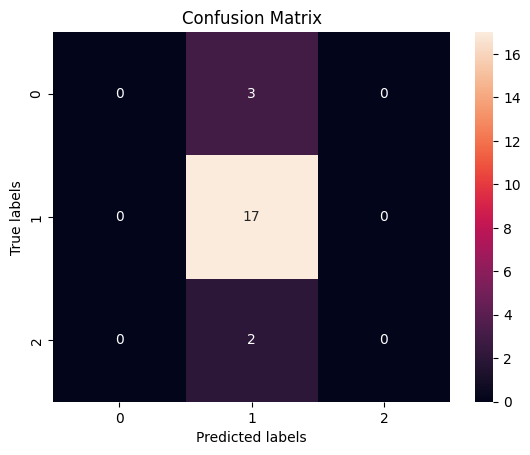

In [38]:
#real labels initial 
# Support Vector Machines
classifiers(tfidf_matrix, real_labels, 'svm')

logistic
Accuracy: 0.8636
Precision: 0.7932
F1 Score: 0.8192


(0.8636363636363636, 0.7931818181818181, 0.819164619164619)

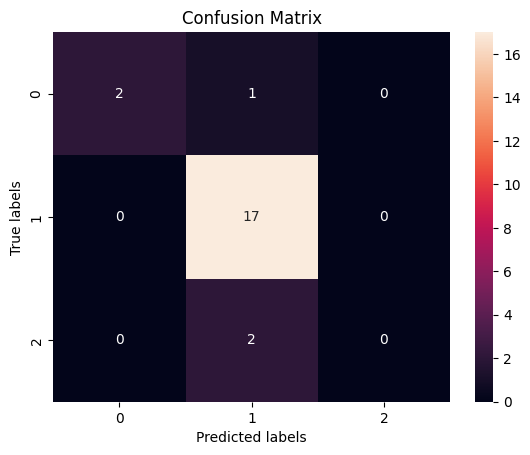

In [39]:
# Logistic Regression
classifiers(tfidf_matrix, real_labels, 'logistic')
    

naive_bayes
Accuracy: 0.8636
Precision: 0.7932
F1 Score: 0.8192


(0.8636363636363636, 0.7931818181818181, 0.819164619164619)

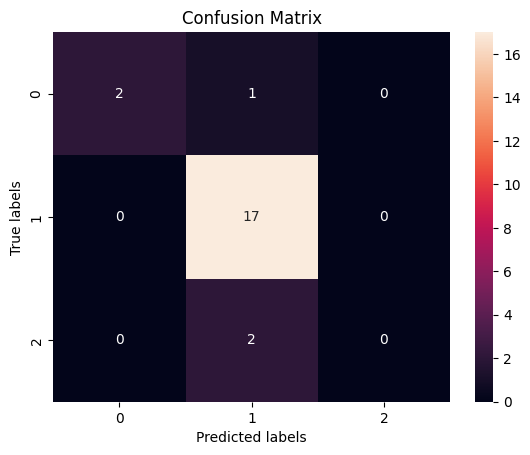

In [40]:
# Naive Bayes
classifiers(tfidf_matrix, real_labels, 'naive_bayes')
    

In [20]:
tfidf_matrix

,absolute,absolutely,access,accommodate,accommodating,accompanying,accordingly,accounting,accustomed,acknowledgment,...,yelled,yelling,yellow,yogurt,youll,young,youre,youve,yummy,zentrum
ATK_Doc2_Au_Cheval_Chicago.docx.txt_restaurant,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
EH_Doc4_Everyday_Cafe_Review.txt_restaurant,0.0,0.0,0.162728,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
EH_Doc3_Cinerella_Bakery_Review.txt_restaurant,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
EH_Doc5_Oleana_Review.txt_restaurant,0.0,0.0,0.000000,0.000000,0.0,0.0,0.073312,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
EH_Doc2_House_of_Nanking_Review.txt_restaurant,0.0,0.0,0.000000,0.109353,0.0,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
OP_Doc5_Incredible-Hilton-Experience.txt_hotel,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
OP_Doc4_Lack-Follow-Langham.txt_hotel,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
OP_Doc2_Great-Experience-London.txt_hotel,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
OP_Doc1_The-Peninsula-Is.txt_hotel,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [111]:
#Classification with SMOTE balanced data 
def classifiers(x, y, model_type, cv=3, oversample=False):
    
    if oversample:
        # Get the count of each class in y
        class_counts = pd.Series(y).value_counts()
        
        # Determine the smallest class size for SMOTE k_neighbors
        min_class_size = class_counts.min()
        
        # Set k_neighbors to a value smaller than or equal to the smallest class size
        smote = SMOTE(k_neighbors=min_class_size - 1)
        x, y = smote.fit_resample(x, y)


    
    if model_type == 'svm':
        print("svm")
        model = SVC()

    elif model_type == 'logistic':
        print("logistic")
        model = LogisticRegression()

    elif model_type == 'naive_bayes':
        print("naive_bayes")
        model = MultinomialNB()
    
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
    model.fit(X_train, y_train)

    predictions = model.predict(X_test)
    
    accy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions, average='weighted')
    f1 = f1_score(y_test, predictions, average='weighted')

    cm = confusion_matrix(y_test, predictions)
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax)
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix') 

    print(f"Accuracy: {accy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"F1 Score: {f1:.4f}")

    return accy, precision, f1


svm
Accuracy: 0.9767
Precision: 0.9784
F1 Score: 0.9767


(0.9767441860465116, 0.9784053156146179, 0.9767097329888028)

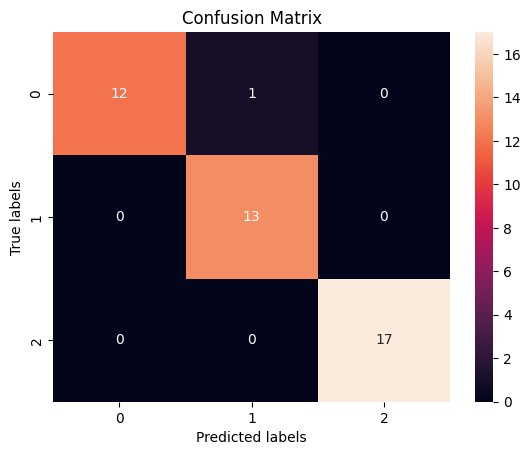

In [87]:
# SVM with oversampling
classifiers(tfidf_matrix, real_labels, 'svm', oversample=True)


logistic
Accuracy: 0.9767
Precision: 0.9784
F1 Score: 0.9767


(0.9767441860465116, 0.9784053156146179, 0.9767097329888028)

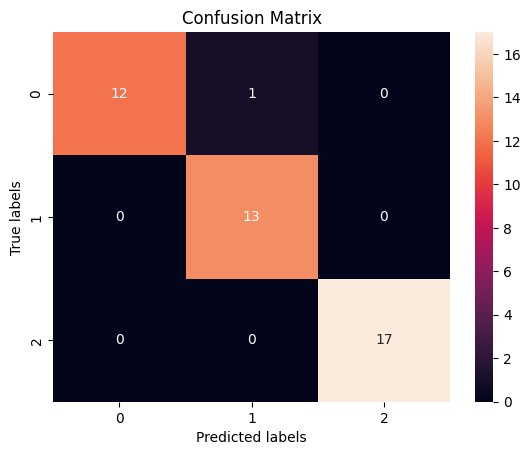

In [88]:
#Logistic Regression with oversampling
classifiers(tfidf_matrix, real_labels, 'logistic', oversample=True)

naive_bayes
Accuracy: 1.0000
Precision: 1.0000
F1 Score: 1.0000


(1.0, 1.0, 1.0)

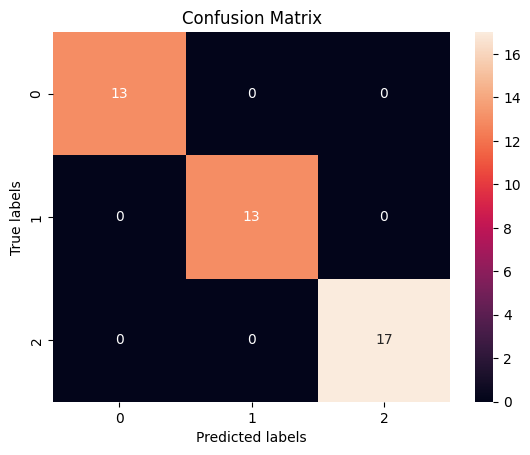

In [89]:
# NB with oversampling
classifiers(tfidf_matrix, real_labels, 'naive_bayes', oversample=True)

In [90]:
# ****Phrase Extraction****** 
data['phrases'] = data['processed_text'].apply(extract_phrases)

In [91]:
def tfidf_with_phrases(corpus, phrases, titles, ngram_range=(1, 1)):
    combined_text = [' '.join(x) for x in zip(corpus, phrases)]
    
    Tfidf = TfidfVectorizer(ngram_range=ngram_range)

    TFIDF_matrix = Tfidf.fit_transform(combined_text)

    words = Tfidf.get_feature_names_out()
    matrix = pd.DataFrame(TFIDF_matrix.toarray(), columns=words, index=titles)
    return matrix

In [92]:
tfidf_matrix_with_phrases = tfidf_with_phrases(final_processed_text, data['phrases'], titles, ngram_range=(1, 2))

svm
Accuracy: 0.9302
Precision: 0.9433
F1 Score: 0.9293


(0.9302325581395349, 0.9433139534883721, 0.9292911683693038)

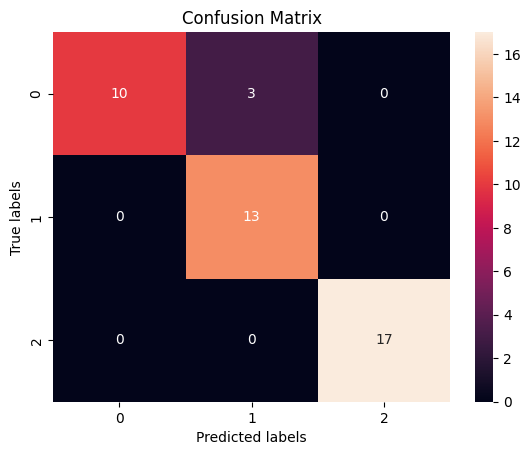

In [93]:
classifiers(tfidf_matrix_with_phrases, real_labels, 'svm', oversample=True)

logistic
Accuracy: 0.9767
Precision: 0.9784
F1 Score: 0.9767


(0.9767441860465116, 0.9784053156146179, 0.9767097329888028)

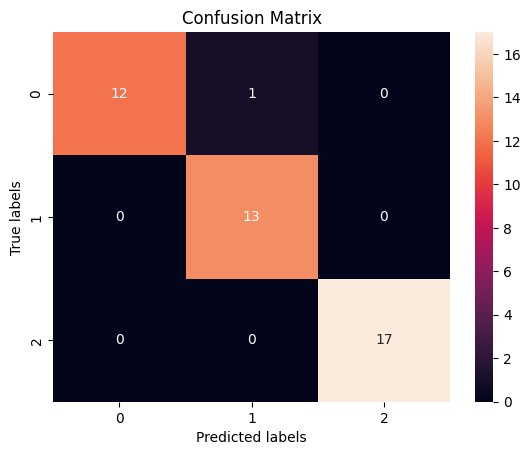

In [94]:
classifiers(tfidf_matrix_with_phrases, real_labels, 'logistic', oversample=True)

naive_bayes
Accuracy: 1.0000
Precision: 1.0000
F1 Score: 1.0000


(1.0, 1.0, 1.0)

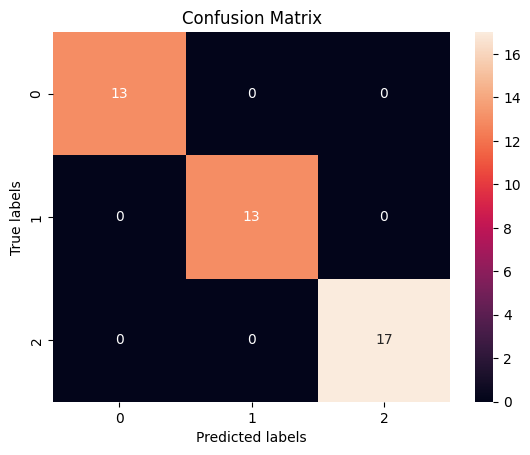

In [95]:
classifiers(tfidf_matrix_with_phrases, real_labels, 'naive_bayes', oversample=True)

In [96]:
#N-Gram Analysis********** 

In [112]:
from sklearn.feature_extraction.text import TfidfVectorizer

def tfidf_with_ngrams(corpus, titles, ngram_range=(1, 1)):
    Tfidf = TfidfVectorizer(ngram_range=ngram_range)

    TFIDF_matrix = Tfidf.fit_transform(corpus)

    words = Tfidf.get_feature_names_out()
    matrix = pd.DataFrame(TFIDF_matrix.toarray(), columns=words, index=titles)
    return matrix

In [ ]:
#  bigrams (n=2)
tfidf_matrix_with_ngrams = tfidf_with_ngrams(final_processed_text, titles, ngram_range=(1, 2))

svm
Accuracy: 0.9535
Precision: 0.9597
F1 Score: 0.9532


(0.9534883720930233, 0.9596899224806201, 0.9532115171650056)

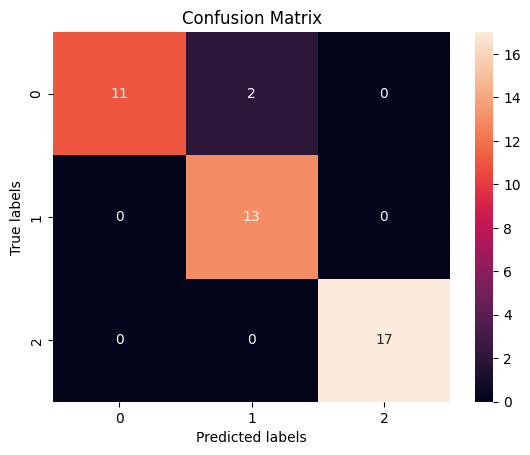

In [113]:
classifiers(tfidf_matrix_with_ngrams, real_labels, 'svm', oversample=True)

logistic
Accuracy: 0.9535
Precision: 0.9597
F1 Score: 0.9532


(0.9534883720930233, 0.9596899224806201, 0.9532115171650056)

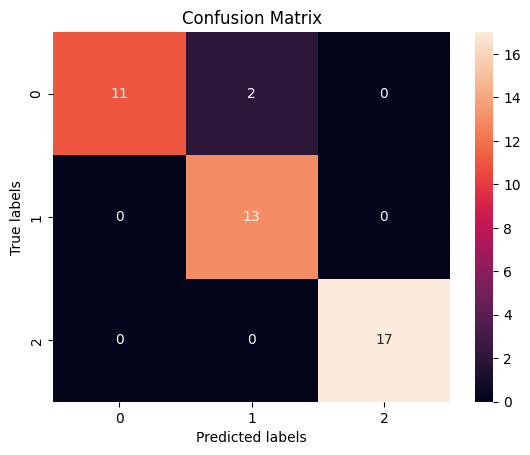

In [114]:
classifiers(tfidf_matrix_with_ngrams, real_labels, 'logistic', oversample=True)

naive_bayes
Accuracy: 1.0000
Precision: 1.0000
F1 Score: 1.0000


(1.0, 1.0, 1.0)

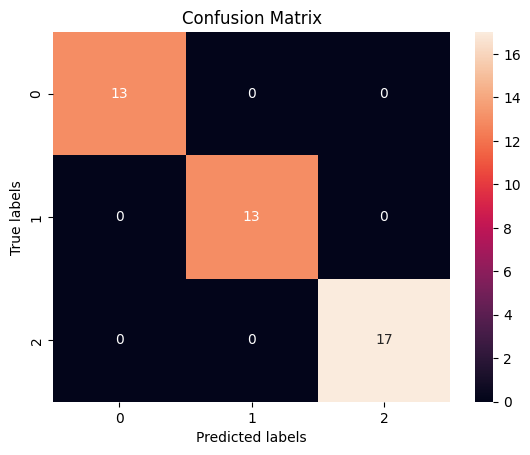

In [115]:
classifiers(tfidf_matrix_with_ngrams, real_labels, 'naive_bayes', oversample=True)